<a href="https://colab.research.google.com/github/laouds91/Amazon-sentiment-analysis/blob/master/Copy_of_Capstone_Final_version_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import all Libary and Python packages**:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
import re
from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk import word_tokenize,sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
nltk.download('punkt')

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Load Data from Google Drive:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Exploration :**

In [ ]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/644_1225_compressed_Amazon_Unlocked_Mobile.csv.zip')

In [ ]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [ ]:
df.shape

(413840, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


In [ ]:
df.describe()

,Price,Rating,Review Votes
count,407907.000000,413840.000000,401544.000000
mean,226.867155,3.819578,1.507237
std,273.006259,1.548216,9.163853
min,1.730000,1.000000,0.000000
25%,79.990000,3.000000,0.000000
50%,144.710000,5.000000,0.000000
75%,269.990000,5.000000,1.000000
max,2598.000000,5.000000,645.000000


In [ ]:
print(" Summary of numerical features : \n", df.describe())


 Summary of numerical features : 
                Price         Rating   Review Votes
count  407907.000000  413840.000000  401544.000000
mean      226.867155       3.819578       1.507237
std       273.006259       1.548216       9.163853
min         1.730000       1.000000       0.000000
25%        79.990000       3.000000       0.000000
50%       144.710000       5.000000       0.000000
75%       269.990000       5.000000       1.000000
max      2598.000000       5.000000     645.000000


In [ ]:
print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))


Total number of reviews:  413840

Total number of brands:  385

Total number of unique products:  4410

Percentage of reviews with neutral sentiment : 7.68%

Percentage of reviews with positive sentiment : 68.86%

Percentage of reviews with negative sentiment : 23.45%


**Data Visualization:**


Text(0, 0.5, 'Count')

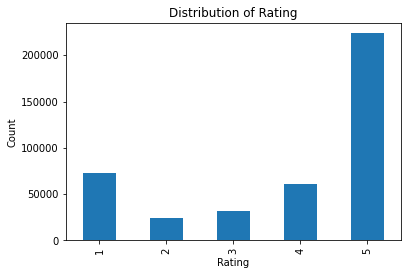

In [ ]:
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

In [ ]:
brands = df["Brand Name"].value_counts()

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

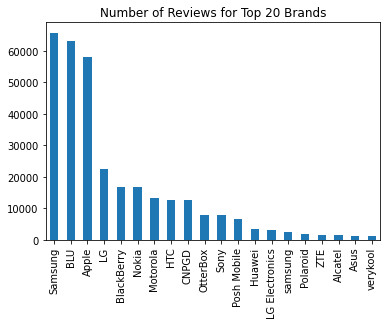

In [ ]:
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

Text(0, 0.5, 'Count')

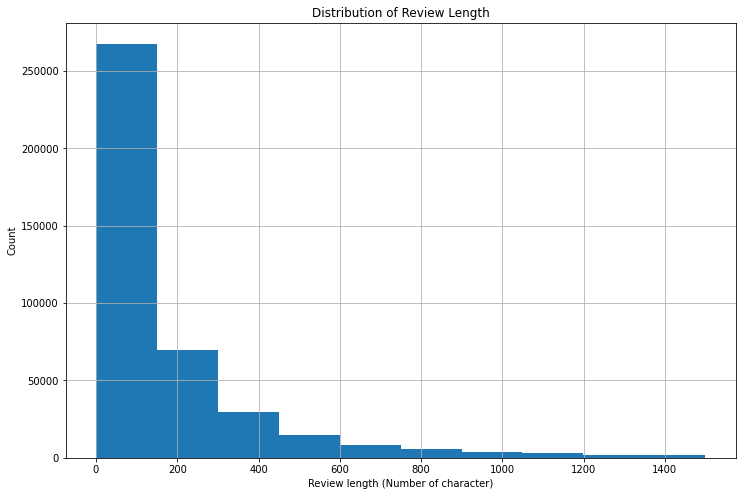

In [ ]:
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

**Data preperation :**

1. First step of data preparation is I m going to use 50% of the data, it will be randomly selected. Also I will consider review with a positive sentiment that has a rating 4 or 5 and encode them as 1 and negative sentiment that has a rating 1 or 2 and encode them as 0 and I will drop all neutral sentiment reviews that has a rating of 3.

In [ ]:
df = df.sample(frac=0.1, random_state=0) 
df.dropna(inplace=True)
df = df[df['Rating'] != 3]
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
134801,BLU Studio 5.0 C HD - Unlocked Cell Phones - R...,BLU,2000.00,5,"For the price I paid for this devices, its fan...",0.0,1
123493,Blu LIFE 8 Unlocked (Pink),BLU,199.98,5,love love love it....good buy...recommend to a...,0.0,1
335592,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,Samsung,299.99,4,Good,0.0,1
246353,"Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...",Motorola,82.00,1,Not good. Returned first phone and they sent m...,0.0,0
273324,Nokia Lumia 920 32GB Unlocked GSM 4G LTE Windo...,Nokia,149.35,4,Met expectations! I'm very satisfied!Even arri...,1.0,1


2. Split the data set into training set and validation set and show a sample of review from the training set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)
print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 27799 training examples and 3089 validation examples. 

Show a review in the training set : 
 good product and fast shipping. thank you.


The aim of this project is to classify the review into positive and negative sentiment. first I will convert the text into a numerical representation and fit this numerical representation into a machine learning algorithms. 

The most common approach of word embedding is frequency based embedding as Bag of Words model. BOW Model is a way of extracting features from text for use in modeling.

**Text Preprocessing:**


1.   Remove Html tags using BeautifulSoup
2.   Remove non-character such as digits and symbols
3.   Convert to lower case 
4.   Remove stop words "the" "and" "a" "this" .....
5.   Convert to root words by stemming







In [ ]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  
    letters_only = re.sub("[^a-zA-Z]", " ", text) 
    words = letters_only.lower().split() 
    
    if remove_stopwords: 
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: 
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True: 
        return (words)
    
    return( " ".join(words))

In [ ]:
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B0193D539M?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP cli

Show a cleaned review in the training set : 
 good product and fast shipping thank you


**NAive Bayes model**

After text preprocessing and inputing the clean data set in the training model, now I m going to use the SKLEARN library countvectorizer feature to implement tokenization and occurence counting for the same class.
first step is to transform the training data to a document matrix with the countvectorizer feature from sklearn

In [ ]:
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])

mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 19607 

Show some feature names : 
 ['aa', 'areable', 'boot', 'clean', 'crushing', 'distortions', 'excatly', 'frills', 'heart', 'inverter', 'lolit', 'movie', 'over', 'predictable', 'reconnecting', 'scaling', 'soldto', 'tapped', 'ubuntu', 'wedges']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9184

AUC score : 0.8790

Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.80      0.83       778
           1       0.93      0.96      0.95      2311

    accuracy                           0.92      3089
   macro avg       0.90      0.88      0.89      3089
weighted avg       0.92      0.92      0.92      3089


Confusion Matrix : 
 [[ 622  156]
 [  96 2215]]


**TFIDF Vectorizer with logistic regression**

TfidfVectorizer - It is a technique used for natural language processing, that transforms text to feature vectors that can be used as input to the estimator. Also in sklearn library, TFIDFVECTORIZER implements both tokenization and tf-idf weighted counting in a single class. 

the following codes are to convert and transform the training data to a document term matrix with tfidfvectorizer imported from SKLearn and than input top a logistic regression model


In [ ]:
tfidf = TfidfVectorizer(min_df=5) 
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) 
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 5987 

Show some feature names : 
 ['00', 'changing', 'fall', 'letting', 'primarily', 'stars']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Display of top features with lowest and highest coeficcients 


In [ ]:
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'return' 'disappointed' 'waste' 'horrible' 'worst' 'poor' 'slow'
 'stopped' 'doesn']

Top 10 features with largest coefficients : 
['great' 'love' 'excellent' 'perfect' 'good' 'easy' 'best' 'far' 'amazing'
 'awesome']


input the model in a regression logistic model and display the confusion matrix


In [ ]:
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9310

AUC score : 0.8985

Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.83      0.86       778
           1       0.94      0.96      0.95      2311

    accuracy                           0.93      3089
   macro avg       0.92      0.90      0.91      3089
weighted avg       0.93      0.93      0.93      3089


Confusion Matrix : 
 [[ 648  130]
 [  83 2228]]


**Gridesearch and pipeline**

in SKlearn library we can use the pipeline to chain multiple features to one. this is useful as there is often a fixed sequence of steps in processing the data, first we build the pipeline , we do a grid search and evaluate the model.



In [ ]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

KeyboardInterrupt: ignored

**Word2vec**:

Another common aproach of word ebedding is prediction based embedding , as wor2vec model. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space.

for this part i will use the gensim libary then i m gonna git the feature vector of amazon mobile reviews to random forest classifier.




Word2vec model takes a list of sentences as inputs and output word vector representation for words in the vocab list created, first we gonna use punkt package this tokenizer divides a text into a list of sentences. And parse each review in the training set into sentenses .


In [ ]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences

In [ ]:
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

27768 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['good', 'product', 'and', 'fast', 'shipping', 'thank', 'you']


Secondly, We need to create a vocaublary list using word2vec model, and we can see the lenght of the feature vector

In [ ]:
num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 4016 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'i', 'it', 'and', 'phone', 'a', 'to', 'is', 'this', 'for']


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Thrid steo is to create the list of words with each word having a vector representation of dimension 300 already choosen . To convert those vector representation to numerical representation we run through each word in a review in the text. After we compute the feature vector of all those words. and calculate the average feature vector to get the numerical representation.  After the transformation we input the feature vector in the training set and compared the vectors in the validation set


In [ ]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [ ]:
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)


# debugging
# print("Checkinf for NaN and Inf")
# print("np.inf=", np.where(np.isnan(trainVector)))
# print("is.inf=", np.where(np.isinf(trainVector)))
# print("np.max=", np.max(abs(trainVector)))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/B0193D539M?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP cli

Training set : 27799 feature vectors with 300 dimensions
Validation set : 3089 feature vectors with 300 dimensions


**Random forest classifier**

we can input our vectors of reviews in the random forest and print our confusion matrix:


In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.9278

AUC score : 0.8972

Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.84      0.85       778
           1       0.95      0.96      0.95      2311

    accuracy                           0.93      3089
   macro avg       0.91      0.90      0.90      3089
weighted avg       0.93      0.93      0.93      3089


Confusion Matrix : 
 [[ 650  128]
 [  95 2216]]


**Word cloud for sentiment 1 and zero for all reviews for apple product**

In [ ]:
def create_word_cloud(brand, sentiment):
    try: 
        df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df_brand.sample(frac=0.1)
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Reviews"]
            
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Reviews"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except: 
        pass

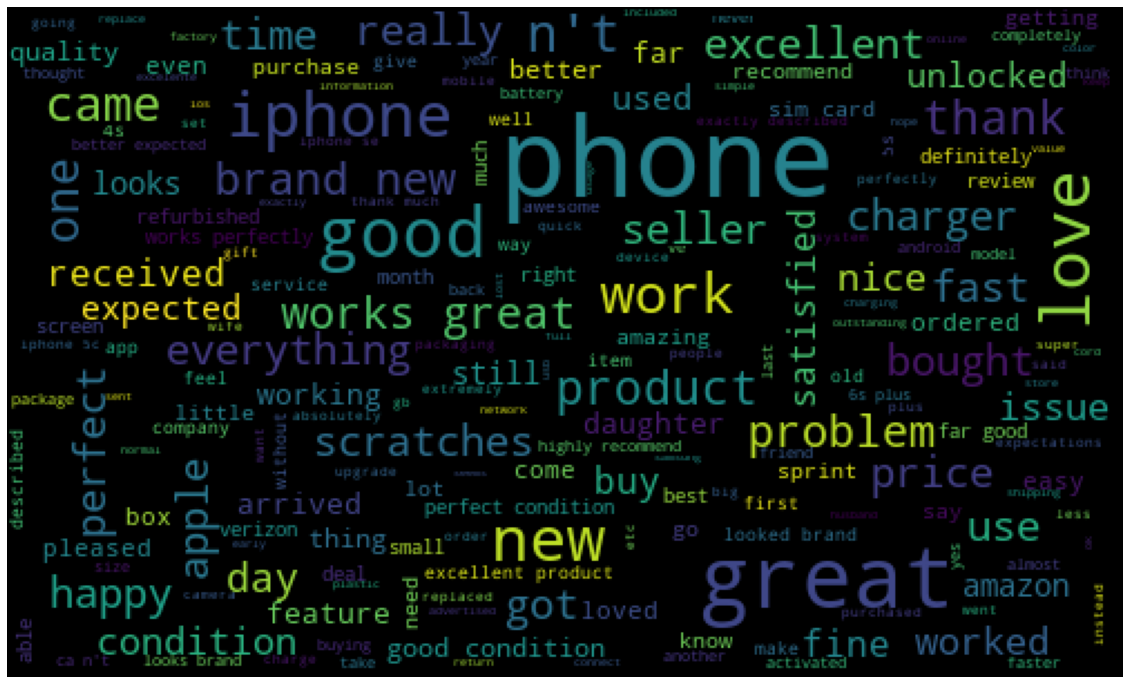

In [ ]:
create_word_cloud(brand='Apple', sentiment=1)

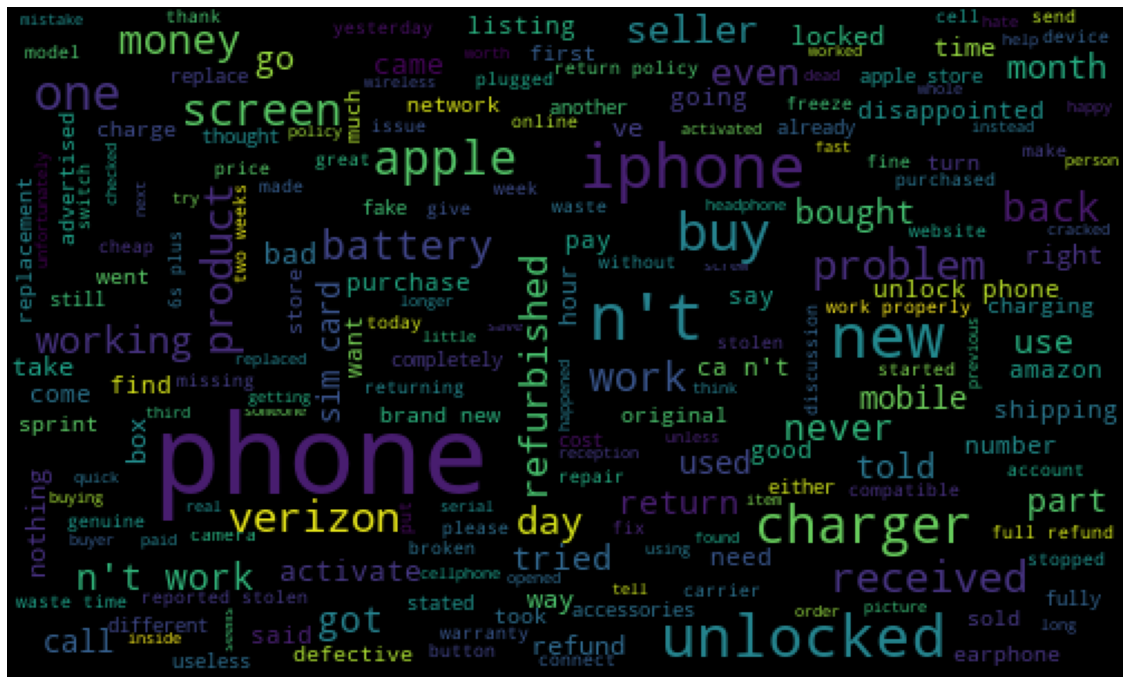

In [ ]:
create_word_cloud(brand='Apple', sentiment=0)